# **YouTube Subscriber Count Prediction**

# Part 1: Introduction

We sought to better understand the factors that led to channel success on YouTube, specifically, the number of subscribers a channel has. We selected a dataset with information about over 1 million channels on YouTube, containing attributes such as channel name, description, keywords, subscriber count, views, join date, country, and more. By utilizing these features along with some engineered features, we hope to find the most important factors that drive channel growth on YouTube.

# Part 2: Data Loading, EDA, Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import matplotlib.patheffects as pe
from sklearn.metrics import mean_squared_error, r2_score
from transformers import pipeline
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the kaggle directory and
!mkdir -p ~/.kaggle
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d asaniczka/2024-youtube-channels-1-million
# Unzip folder in Colab content folder
!unzip /content/2024-youtube-channels-1-million.zip

Dataset URL: https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million
License(s): ODC Attribution License (ODC-By)
2024-youtube-channels-1-million.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/2024-youtube-channels-1-million.zip
replace youtube_channels_1M_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
yc_df = pd.read_csv('youtube_channels_1M_clean.csv')

# Check out the first five rows
yc_df.head()

,channel_id,channel_link,channel_name,subscriber_count,banner_link,description,keywords,avatar,country,total_views,total_videos,join_date,mean_views_last_30_videos,median_views_last_30_videos,std_views_last_30_videos,videos_per_week
0,UCUMHFa347GD8EIRaVVuxR8Q,/@TonettaClay,Tonetta Clay,781,https://yt3.googleusercontent.com/bj2C0MOj3SMi...,My name is Tonetta or Toni for short and I'm d...,NaN,https://yt3.googleusercontent.com/cUmKB4Zet1SX...,NaN,227567.0,1984.0,2015-12-08,10.866667,6.5,13.922963,1.50
1,UC28mqg7IlYWEhrZwHb72IQA,/@FoodnHappinessVeena,Food 'n' Happiness,0,NaN,"Hello viewers.\n I am Veena from Mangalore, Ka...","food n happiness, food and happiness, food, Fo...",https://yt3.googleusercontent.com/lY_u-8bLWNgA...,India,592961.0,158.0,2020-05-08,1448.066667,1510.0,869.364401,0.00
2,UCoLwWY9zQ7Jp8aDtYUszmYg,/@TimShieff,Tim Shieff,166000,https://yt3.googleusercontent.com/2KC8Lj8RF3uF...,The journey of rediscovery.\n\nhttps://rdscvr.com,"Tim, shieff, timothy, health, human, spiritual...",https://yt3.googleusercontent.com/-aNZLP23AnkX...,United Kingdom,27250763.0,372.0,2006-03-19,5456.933333,3430.0,4322.803149,0.00
3,UCAQOeJwsgBMC74-OjjcQcJA,/@JerryAndJulieMusic,Jerry & Julie Music,1090,https://yt3.googleusercontent.com/dI6Oq0iOhx-c...,Welcome to Jerry & Julie Music. We hope you w...,"jerryandjuliemusic, jerryspianobar, juliesguit...",https://yt3.googleusercontent.com/c41pe3_aA75h...,United States,339906.0,913.0,2010-03-27,75.966667,47.5,113.374448,4.00
4,UCOqwGhI1AmpWwxMYw9D_fqw,/@KichuandYugiMagizhakam,Kichu and Yugi Magizhakam,1160,https://yt3.googleusercontent.com/CXrATV8NKPRg...,Hi friends welcome to my channel...I'm Devi mo...,NaN,https://yt3.googleusercontent.com/FDA5pc1ZQ5jT...,NaN,288328.0,476.0,2023-12-21,85.700000,66.0,72.032007,1.25


## **2.1 EDA & Data Visualization**
According to the Kaggle page, the dataset is sampled randomly from all Youtube channels. With >1 Million indices (out of roughly 51 million on the website), its data very likely is a good representation of channel behavior and success on the site as a whole.

As part of Exploratory Data Analysis, we will investigate the following about the dataset:


*   Sparsity (NaNs in each row)
*   Non-zero subscriber count distribution
*   Correlation between subscriber count & number of published videos (How many channels with non-zero subscribers have zero videos? How many channels with non-zero videos have zero subscribers?)

We will dive deeply into the subscriber count distribution, since we are using this parameter as our data label. We will investigate possible data imbalance in this section.



In [ ]:
# Check that dimensions are correct
yc_df.shape

(1095242, 16)

In [ ]:
# Descriptive statistics
yc_df.describe()

,subscriber_count,total_views,total_videos,mean_views_last_30_videos,median_views_last_30_videos,std_views_last_30_videos,videos_per_week
count,1.095242e+06,1.094490e+06,1.094985e+06,1.059085e+06,1.059085e+06,1.059085e+06,1.059085e+06
mean,6.718270e+04,2.558005e+07,4.139291e+02,4.173914e+04,1.937563e+04,6.503651e+04,6.252839e-01
std,8.592589e+05,5.176393e+08,3.910517e+03,1.322847e+06,8.900375e+05,1.908503e+06,1.535874e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.300000e+01,8.288000e+03,2.300000e+01,8.742857e+01,4.000000e+01,7.678400e+01,0.000000e+00
50%,3.730000e+02,8.386200e+04,8.400000e+01,4.253333e+02,1.455000e+02,5.438977e+02,0.000000e+00
75%,2.900000e+03,6.678882e+05,2.670000e+02,2.587567e+03,7.525000e+02,4.089039e+03,5.000000e-01
max,2.440000e+08,1.788442e+11,1.248360e+06,6.889384e+08,6.712840e+08,1.069565e+09,7.500000e+00


In [ ]:
yc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095242 entries, 0 to 1095241
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   channel_id                   1095242 non-null  object 
 1   channel_link                 1095242 non-null  object 
 2   channel_name                 1095182 non-null  object 
 3   subscriber_count             1095242 non-null  int64  
 4   banner_link                  766877 non-null   object 
 5   description                  819743 non-null   object 
 6   keywords                     547203 non-null   object 
 7   avatar                       1095242 non-null  object 
 8   country                      620059 non-null   object 
 9   total_views                  1094490 non-null  float64
 10  total_videos                 1094985 non-null  float64
 11  join_date                    1095220 non-null  object 
 12  mean_views_last_30_videos    1059085 non-n

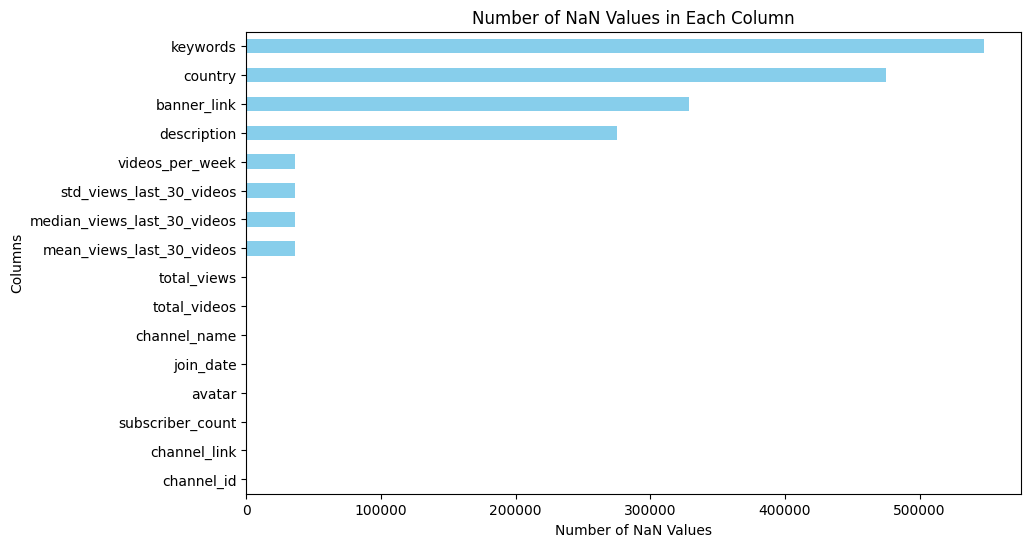

In [ ]:
# visualizing null values in each column
nan_counts = yc_df.isnull().sum()

# sort columns by NaN count
nan_counts_sorted = nan_counts.sort_values()

plt.figure(figsize=(10, 6))
nan_counts_sorted.plot(kind='barh', color='skyblue')
plt.title('Number of NaN Values in Each Column')
plt.xlabel('Number of NaN Values')
plt.ylabel('Columns')
plt.show()

Briefly investigating the columns `videos_per_week`, `std_views_last_30_videos`, `median_views_last_30_videos`, and `mean_views_last_30_videos` to see if all NaNs are from the same rows. We know that all of them have the same number of NaNs in the broader database. Selecting rows with null values from one column, we count the number of non-nulls in the three other columns and find that there are none. So, we can conclude that the nulls from all of these are probably from the same cause (no videos uploaded in the last 30 days).

In [ ]:
yc_df[yc_df['videos_per_week'].isna()][['videos_per_week', 'median_views_last_30_videos', 'mean_views_last_30_videos', 'std_views_last_30_videos']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 36157 entries, 8 to 1095239
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   videos_per_week              0 non-null      float64
 1   median_views_last_30_videos  0 non-null      float64
 2   mean_views_last_30_videos    0 non-null      float64
 3   std_views_last_30_videos     0 non-null      float64
dtypes: float64(4)
memory usage: 1.4 MB


In [ ]:
# Column Datatypes
yc_df.dtypes

channel_id                      object
channel_link                    object
channel_name                    object
subscriber_count                 int64
banner_link                     object
description                     object
keywords                        object
avatar                          object
country                         object
total_views                    float64
total_videos                   float64
join_date                       object
mean_views_last_30_videos      float64
median_views_last_30_videos    float64
std_views_last_30_videos       float64
videos_per_week                float64
dtype: object

<Axes: >

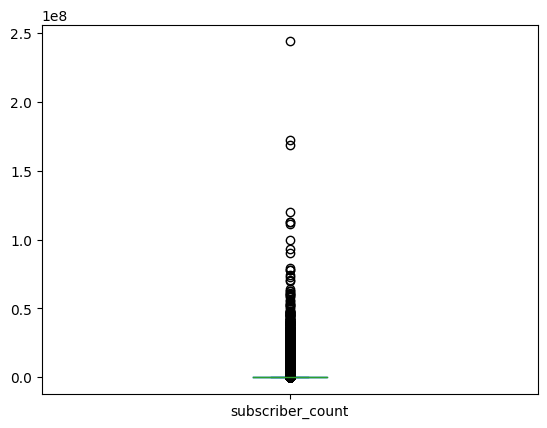

In [ ]:
# Distribution of subscriber count
yc_df['subscriber_count'].plot(kind='box')

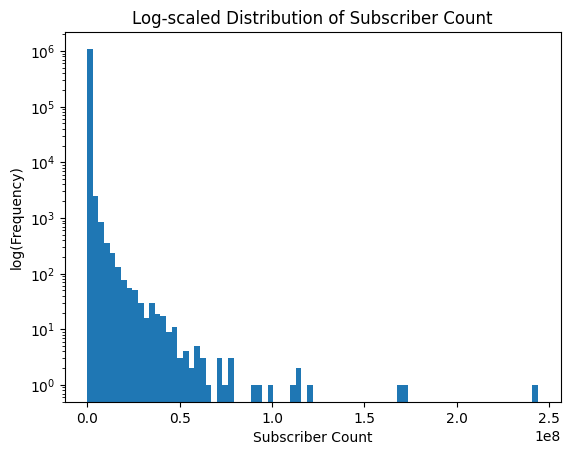

In [ ]:
fig = plt.figure(1)
plt.hist(yc_df['subscriber_count'], bins = 80, log = True)
plt.ylabel("log(Frequency)")
plt.xlabel("Subscriber Count")
plt.title("Log-scaled Distribution of Subscriber Count")
plt.show()

In the histogram above, we used log-scaling to be able to see higher subscriber count bins at all. Using this, we can see the data is extremely left-skewed, and data becomes extremely sparse at around 50 million subscribers. Any channel with more than 50 million subscribers can be deemed an outlier. However, removing these channels is not desirable, since we are interested in what makes channels successful. We will explore alternatives in following sections.

The distribution of low, non-zero subscriber counts is also important to understand. Below, we do some more investigation into the distribution of sub counts below 2000.

In [ ]:
sub_counts = yc_df['subscriber_count'].value_counts()
# print(sub_counts)
zero_count = sub_counts.get(0, 0)
print("There are", zero_count, "channels with 0 subscribers.")

percent_0 = (zero_count / len(yc_df)).round(4) * 100
percent_leq_10 = ((yc_df['subscriber_count'] <= 10).sum() / len(yc_df)).round(3) * 100
percent_leq_100 = ((yc_df['subscriber_count'] <= 100).sum() / len(yc_df)).round(3) * 100
percent_leq_1000 = ((yc_df['subscriber_count'] <= 1000).sum() / len(yc_df)).round(3) * 100
percent_100_2000 = ((yc_df[yc_df['subscriber_count'] > 100]['subscriber_count'] <= 2000).sum() / len(yc_df)).round(4) * 100
percent_geq_10000 = ((yc_df['subscriber_count'] >= 10000).sum() / len(yc_df)).round(3) * 100
percent_geq_100000 = ((yc_df['subscriber_count'] >= 100000).sum() / len(yc_df)).round(3) * 100

print(percent_0, "% of channels have 0 subscribers.")
print(percent_leq_10, "% of channels have less than 10 subscribers.")
print(percent_leq_100, "% of channels have less than 100 subscribers.")
print(percent_leq_1000, "% of channels have less than 1000 subscribers.")
print(percent_100_2000, "% of channels have between 100 and 2000 subscribers.")
print(percent_geq_10000, "% of channels have 10000 or more subscribers.")
print(percent_geq_100000, "% of channels have 100000 or more subscribers.")

There are 64546 channels with 0 subscribers.
5.89 % of channels have 0 subscribers.
16.2 % of channels have less than 10 subscribers.
35.3 % of channels have less than 100 subscribers.
62.3 % of channels have less than 1000 subscribers.
35.9 % of channels have between 100 and 2000 subscribers.
15.5 % of channels have 10000 or more subscribers.
5.7 % of channels have 100000 or more subscribers.


Based on the fact that only ~6% of channels have 0 subscribers while 62.3% of channels have less than 1000 subscribers, it's interesting to see what the label distribution is for this subset. We will make a non-log-scaled histogram to investigate this.

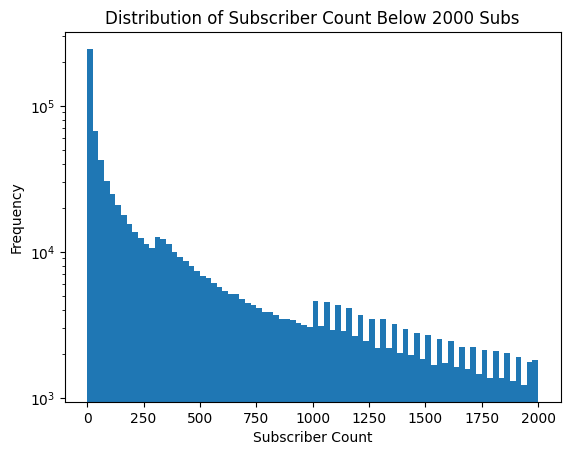

In [ ]:
low_sub_df = yc_df[yc_df['subscriber_count'] <= 2000]['subscriber_count']
fig = plt.figure(1)
plt.hist(low_sub_df, bins = 80, log = True)
plt.ylabel("Frequency")
plt.xlabel("Subscriber Count")
plt.title("Distribution of Subscriber Count Below 2000 Subs")
plt.show()

Overall, we can see that 0 subscribers is the biggest bin. However, this does not actually represent the majority of all channels. Early on, we anticipated a huge issue being that the majority of all channels have no subscribers at all, which would mean that we would have trouble predicting non-zero labels. In this case, we may have considered predicting whether or not a youtube channel has subscribers at all.

That early worry is now shown to not be the case. Since only 5.89% of channels have 0 subscribers, we have about 94% of the data showing non-zero labels. The data does get exponentially more sparse as subscriber count increases, but we do have sufficient data for meaningfully proportioned bins.

From the percentages calculated above, we have:
 * 35.3% of channels have less than 100 subscribers
 * 35.9% of channels have between 100 and 2000 subscribers
 * Therefore, 28.8% of channels have more than 2000 subscribers.

Since subscriber count is so sparse and does follow a roughly exponential decay, we decided to investigate log(subscriber count) as a direct substitute for data labeling. This is a computationally simple proxy, so reconstructing actual subscriber count is trivial.

We can see the distribution below. Subscriber count is log-scaled but Frequency is not. As we can see, the distribution is not quite even, but it is significantly less sparse than the non-log-scaled data, decreasing the significance of outliers and lending it better to resampling methods.

We calculate log(subscriber count + 1), that is, use `np.log1p()`, to avoid negative infinity for channels with 0 subscribers.

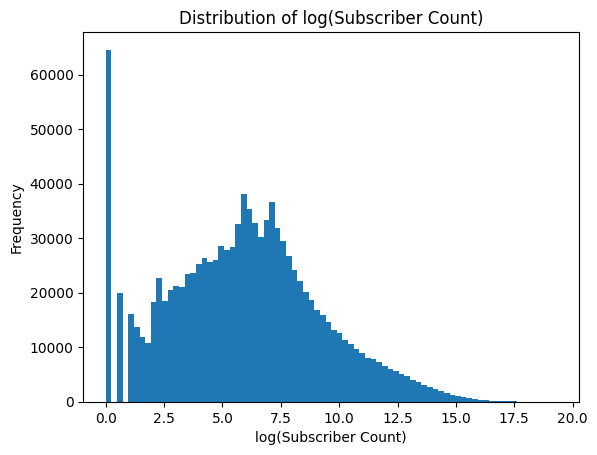

In [ ]:
log_subs_df = np.log1p(yc_df['subscriber_count'])
fig = plt.figure(1)
plt.hist(log_subs_df, bins = 80)
plt.ylabel("Frequency")
plt.xlabel("log(Subscriber Count)")
plt.title("Distribution of log(Subscriber Count)")
plt.show()

## 2.2: Preprocessing

We first look at the number of NaNs to analyze the completeness of our data.

In [ ]:
# NaNs in each row
yc_df.isnull().sum(axis = 0)

channel_id                          0
channel_link                        0
channel_name                       60
subscriber_count                    0
banner_link                    328365
description                    275499
keywords                       548039
avatar                              0
country                        475183
total_views                       752
total_videos                      257
join_date                          22
mean_views_last_30_videos       36157
median_views_last_30_videos     36157
std_views_last_30_videos        36157
videos_per_week                 36157
dtype: int64

For certain columns, we can assume that NaN values imply zero; these include mean/median/std views in the last 30 videos, and videos_per_week. For these 4 metrics, we can see above that they have the same amount of NaNs. We can guess that these NaNs are a result of computation on invalid values, or division by 0, probably as a result of no videos having ever been uploaded on the channel. These are reasonable to replace with 0.

Other columns have some NaN values that are not necessarily 0 but we don't know what value they should be. These include numerical values like `total_views` and `total_videos`; optional channel customizations or associations, like `channel_name`, `banner_link`, `description`, `keywords`, and `country`; and finally, non-numerical values like `join_date`.

The volume of NaNs for `channel_name`, `total_views`, `total_videos`, and `join_date` is small, so we elect to drop these rows.

We will use the join_date attribute to create a new attribute that stores the number of days ago the channel was created.

The volume of NaNs for optional channel customizations is huge, and also indicate important semantic information about the channel both in terms of 1. binary information (ie. either the channel has it or not) and 2. what the channel is about.

For these, we may decide to reduce the complexity of the data by having binary data indicating the presence or absence of the channel component. This is especially the case for data with information that requires computer vision or image analysis techniques to extract, such as banners and avatars. Time allowing, we will attempt to extract features from lexical data, i.e. description and keywords. These will be done in the next section: Feature Engineering.



In [ ]:
yc_df_cleaned = yc_df.copy()
# drop NaNs in total_views, total_videos, and join_date
yc_df_cleaned.dropna(axis='index', subset=['total_views','total_videos','join_date', 'channel_name'], inplace=True)
# replace NaNs in mean_views, median_views, std_views, and videos_per_week with 0
zero_na_cols = ["mean_views_last_30_videos", "median_views_last_30_videos", "std_views_last_30_videos",
       "videos_per_week"]
yc_df_cleaned[zero_na_cols] = yc_df_cleaned[zero_na_cols].fillna(value=0)

In [ ]:
# alter join_date column to datetime datatype, then create new column that stores the number of days ago the channel was created
yc_df_cleaned['join_date'] = pd.to_datetime(yc_df_cleaned['join_date'])
yc_df_cleaned['days_since_join'] = (pd.Timestamp.today() - yc_df_cleaned['join_date']).dt.days

In [ ]:
yc_df_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
yc_df_cleaned.isnull().sum(axis = 0)

channel_id                          0
channel_link                        0
channel_name                        0
subscriber_count                    0
banner_link                    327808
description                    274966
keywords                       547347
avatar                              0
country                        474570
total_views                         0
total_videos                        0
join_date                           0
mean_views_last_30_videos           0
median_views_last_30_videos         0
std_views_last_30_videos            0
videos_per_week                     0
days_since_join                     0
dtype: int64

# Part 3: Feature Engineering

## 3.1 Binary breakdown of complex features
Add binary encoding for features with many NaNs that we decided not to drop/change to 0 (channel banner, description, keywords, and country) indicating presence or absence of this feature on a channel.

In [ ]:
# add boolean columns
# IMPORTANT: do not rerun this cell after running subsequent cells without re-setting yc_df_cleaned

has_feature = lambda x: not pd.isna(x)

yc_df_cleaned['has_banner'] = yc_df_cleaned['banner_link'].apply(has_feature)
yc_df_cleaned['has_description'] = yc_df_cleaned['description'].apply(has_feature)
yc_df_cleaned['has_keywords'] = yc_df_cleaned['keywords'].apply(has_feature)
yc_df_cleaned['has_country'] = yc_df_cleaned['country'].apply(has_feature)

In [ ]:
# binary encoding for bool columns
encoder = OneHotEncoder(sparse=False, drop='first')

binary_columns = ['has_banner','has_description','has_keywords','has_country']

# Convert the values in these columns to 1.0/0.0
binary_encoded = encoder.fit_transform(yc_df_cleaned[binary_columns])
binary_encoded_df = pd.DataFrame(binary_encoded, columns=binary_columns)
yc_df_cleaned.drop(columns=binary_columns, inplace=True)
yc_df_cleaned = pd.concat([yc_df_cleaned, binary_encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
yc_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094291 entries, 0 to 1094290
Data columns (total 21 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   channel_id                   1094291 non-null  object        
 1   channel_link                 1094291 non-null  object        
 2   channel_name                 1094291 non-null  object        
 3   subscriber_count             1094291 non-null  int64         
 4   banner_link                  766483 non-null   object        
 5   description                  819325 non-null   object        
 6   keywords                     546944 non-null   object        
 7   avatar                       1094291 non-null  object        
 8   country                      619721 non-null   object        
 9   total_views                  1094291 non-null  float64       
 10  total_videos                 1094291 non-null  float64       
 11  join_date  

In [ ]:
yc_df_cleaned.head()

,channel_id,channel_link,channel_name,subscriber_count,banner_link,description,keywords,avatar,country,total_views,...,join_date,mean_views_last_30_videos,median_views_last_30_videos,std_views_last_30_videos,videos_per_week,days_since_join,has_banner,has_description,has_keywords,has_country
0,UCUMHFa347GD8EIRaVVuxR8Q,/@TonettaClay,Tonetta Clay,781,https://yt3.googleusercontent.com/bj2C0MOj3SMi...,My name is Tonetta or Toni for short and I'm d...,NaN,https://yt3.googleusercontent.com/cUmKB4Zet1SX...,NaN,227567.0,...,2015-12-08,10.866667,6.5,13.922963,1.50,3067,1.0,1.0,0.0,0.0
1,UC28mqg7IlYWEhrZwHb72IQA,/@FoodnHappinessVeena,Food 'n' Happiness,0,NaN,"Hello viewers.\n I am Veena from Mangalore, Ka...","food n happiness, food and happiness, food, Fo...",https://yt3.googleusercontent.com/lY_u-8bLWNgA...,India,592961.0,...,2020-05-08,1448.066667,1510.0,869.364401,0.00,1454,0.0,1.0,1.0,1.0
2,UCoLwWY9zQ7Jp8aDtYUszmYg,/@TimShieff,Tim Shieff,166000,https://yt3.googleusercontent.com/2KC8Lj8RF3uF...,The journey of rediscovery.\n\nhttps://rdscvr.com,"Tim, shieff, timothy, health, human, spiritual...",https://yt3.googleusercontent.com/-aNZLP23AnkX...,United Kingdom,27250763.0,...,2006-03-19,5456.933333,3430.0,4322.803149,0.00,6618,1.0,1.0,1.0,1.0
3,UCAQOeJwsgBMC74-OjjcQcJA,/@JerryAndJulieMusic,Jerry & Julie Music,1090,https://yt3.googleusercontent.com/dI6Oq0iOhx-c...,Welcome to Jerry & Julie Music. We hope you w...,"jerryandjuliemusic, jerryspianobar, juliesguit...",https://yt3.googleusercontent.com/c41pe3_aA75h...,United States,339906.0,...,2010-03-27,75.966667,47.5,113.374448,4.00,5149,1.0,1.0,1.0,1.0
4,UCOqwGhI1AmpWwxMYw9D_fqw,/@KichuandYugiMagizhakam,Kichu and Yugi Magizhakam,1160,https://yt3.googleusercontent.com/CXrATV8NKPRg...,Hi friends welcome to my channel...I'm Devi mo...,NaN,https://yt3.googleusercontent.com/FDA5pc1ZQ5jT...,NaN,288328.0,...,2023-12-21,85.700000,66.0,72.032007,1.25,132,1.0,1.0,0.0,0.0


## 3.2 Keyword analysis
In this section we break down the 'keywords' column, which starts as a formatted string, into a list of strings by separating using the comma delimiter. Then we do a brief analysis on the most common keywords (standardizing to all lower case) and how many keywords most channels use.

In [ ]:
# convert keywords into a list of lowercase strings
def string_to_list(s):
    if pd.isna(s):  # preserve nans
        return []
    else:
        return s.lower().split(', ')  # use commas as delimiter

# Apply the function to the column
yc_df_cleaned['keywords'] = yc_df_cleaned['keywords'].apply(string_to_list)

In [ ]:
yc_df_cleaned['num_keywords'] = yc_df_cleaned['keywords'].apply(len)

Below, we make a bar chart of the 25 most commonly used keywords and their frequencies. We also preview the top 100 keywords using the counter object. We can see that many of the keywords are synonymous (gaming, games, gameplay, video games, game) or have a significant overlap (lets play, xbox, walkthrough, playstation, nintendo are all subsets of gaming categories). This highlights great potential to reduce keyword dimensionality and add encoding.

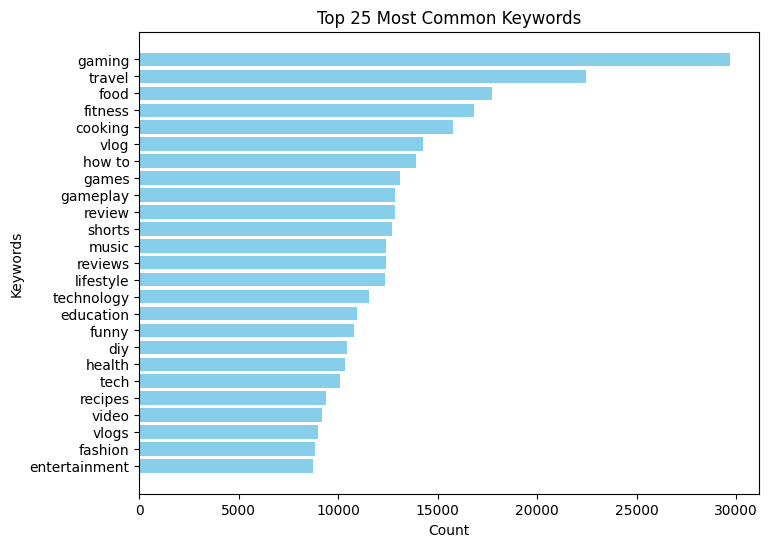

In [ ]:
from collections import Counter

flattened_list = [item for sublist in yc_df_cleaned['keywords'].dropna() for item in sublist]

# count phrases in keywords
word_counts = Counter(flattened_list)

# get top 25 most common keywords
top_25_words = word_counts.most_common(25)

words = [word[0] for word in top_25_words]
counts = [word[1] for word in top_25_words]

# plot top 50 keywords
plt.figure(figsize=(8, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.title('Top 25 Most Common Keywords')
plt.gca().invert_yaxis()
plt.show()

Histogram of number of keywords. This gives us an idea of how many channels have keywords and the distribution of keywords over channels.

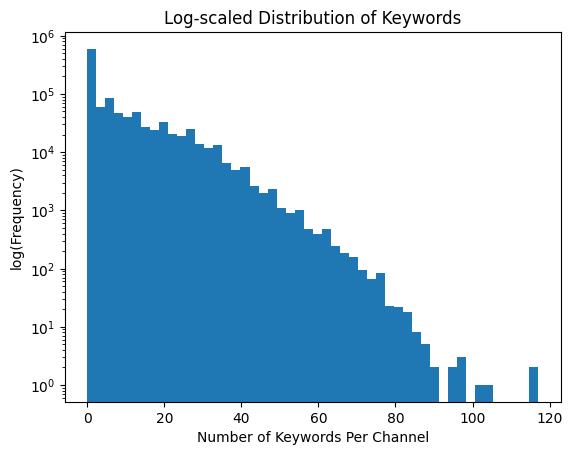

In [ ]:
fig = plt.figure(1)
plt.hist(yc_df_cleaned['num_keywords'], bins = 50, log = True)
plt.ylabel("log(Frequency)")
plt.xlabel("Number of Keywords Per Channel")
plt.title("Log-scaled Distribution of Keywords")
plt.show()

### 3.2.1 Keyword Encoding

To make the keywords into a more usable state, we will break them down into subcategory groupings. For simplicity, we will only categorize the top 100 keywords.

Many of the categories are extremely broad, but this is because we want to minimize the number of categories. We will be doing binary encoding for each of these, not one-hot encoding, since channels may belong to multiple categories.

Even so, having too many categories can cause data sparsity and overfitting. So, many distinct categories are lumped together under broader, more general categories. (ie. beauty, fitness, travel, etc. are all grouped under 'lifestyle').

In [ ]:
keyword_groupings = {"gaming": {"gaming", "gamer", "games", "gameplay", "video games",
                                "game", "lets play", "xbox", "playstation", "nintendo",
                                "ps4", "ps5", "minecraft"},
                     "lifestyle": {'fitness','lifestyle','health','gym','weight loss',
                                   'beauty', 'workout', 'motivation', 'fashion', 'travel',
                                   'family', 'adventure', 'exercise', 'makeup',
                                   'nutrition', 'training', 'travel vlog', 'diet',
                                   'life', 'bodybuilding', 'food', 'cooking','baking'},
                     "guides_tutorials": {'how to', 'education', 'educational',
                                              'diy', 'tutorial', 'tutorials', 'walkthrough',
                                              'walkthroughs', 'tips', 'guide', 'guides',
                                              'science', 'recipes', 'recipe', 'easy recipes'},
                     "technology":{'technology', 'tech', 'cars', 'pc', 'car', 'bmw'},
                     "news_finance":{'digital marketing', 'news', 'real estate',
                                         'business', 'investing', 'investment',
                                         'finance', 'marketing', 'money', 'stock market',
                                         'stocks', 'crypto', 'cryptocurrency', 'make money online'},
                     "entertainment":{'vlog', 'shorts', 'video', 'music', 'entertainment',
                                      'unboxing', 'youtube', 'viral', 'podcast', 'art',
                                      'trending', 'movies', 'review', 'reviews', 'film',
                                      'design', 'anime', 'vlogger', 'asmr', 'sports',
                                      'youtube shorts', 'funny', 'comedy', 'fun'}}

In [ ]:
def has_category_keywords(keywords_list, category, groupings):
    for keyword in keywords_list:
        if keyword in groupings[category]:
            return 1
    return 0

categories = ['gaming', 'lifestyle', 'guides_tutorials', 'technology', 'news_finance', 'entertainment']

for category in categories:
    yc_df_cleaned[category] = yc_df_cleaned['keywords'].apply(lambda x: has_category_keywords(x, category, keyword_groupings))

In [ ]:
display(yc_df_cleaned)

,channel_id,channel_link,channel_name,subscriber_count,banner_link,description,keywords,avatar,country,total_views,...,has_keywords,has_country,has_links,num_keywords,gaming,lifestyle,guides_tutorials,technology,news_finance,entertainment
0,UCUMHFa347GD8EIRaVVuxR8Q,/@TonettaClay,Tonetta Clay,781,https://yt3.googleusercontent.com/bj2C0MOj3SMi...,My name is Tonetta or Toni for short and I'm d...,[],https://yt3.googleusercontent.com/cUmKB4Zet1SX...,NaN,227567.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,UC28mqg7IlYWEhrZwHb72IQA,/@FoodnHappinessVeena,Food 'n' Happiness,0,NaN,"Hello viewers.\n I am Veena from Mangalore, Ka...","[food n happiness, food and happiness, food, f...",https://yt3.googleusercontent.com/lY_u-8bLWNgA...,India,592961.0,...,1.0,1.0,0.0,24,0,1,0,0,0,0
2,UCoLwWY9zQ7Jp8aDtYUszmYg,/@TimShieff,Tim Shieff,166000,https://yt3.googleusercontent.com/2KC8Lj8RF3uF...,The journey of rediscovery.\n\nhttps://rdscvr.com,"[tim, shieff, timothy, health, human, spiritua...",https://yt3.googleusercontent.com/-aNZLP23AnkX...,United Kingdom,27250763.0,...,1.0,1.0,1.0,11,0,1,0,0,0,1
3,UCAQOeJwsgBMC74-OjjcQcJA,/@JerryAndJulieMusic,Jerry & Julie Music,1090,https://yt3.googleusercontent.com/dI6Oq0iOhx-c...,Welcome to Jerry & Julie Music. We hope you w...,"[jerryandjuliemusic, jerryspianobar, juliesgui...",https://yt3.googleusercontent.com/c41pe3_aA75h...,United States,339906.0,...,1.0,1.0,1.0,27,0,0,0,0,0,1
4,UCOqwGhI1AmpWwxMYw9D_fqw,/@KichuandYugiMagizhakam,Kichu and Yugi Magizhakam,1160,https://yt3.googleusercontent.com/CXrATV8NKPRg...,Hi friends welcome to my channel...I'm Devi mo...,[],https://yt3.googleusercontent.com/FDA5pc1ZQ5jT...,NaN,288328.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094286,UCv5MGa5MlPJs-Hnb83MM86Q,/@PAULETTELANVLOG,PAULET TELAN VLOG,687,https://yt3.googleusercontent.com/kg38beaTSCqz...,"\nI'm PAULET TELAN, a Filipina married to a Ca...","[paulet arguelles telan bil, paulet telan, pau...",https://yt3.googleusercontent.com/21fryxg8FIH3...,Canada,116986.0,...,1.0,1.0,0.0,8,0,1,0,0,0,0
1094287,UCv9ddmW76c7aVVx4QscPn-A,/@ellyphysique4068,Elly physique,612,https://yt3.googleusercontent.com/aMeFmq78DhLq...,Be happy stay strong subscribe 🫶,[],https://yt3.googleusercontent.com/oKvSEr0R1K2v...,NaN,149178.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1094288,UC23Wx4sNPxvfjCSlaJrus1A,/@UmaPaul-fb4he,Thali with love,5,NaN,Hii everyone! welcome to my virtual table!😀,[],https://yt3.googleusercontent.com/OYMQFT253jkN...,NaN,296.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1094289,UCB4ztUZpdzX30Y5vdr7J6eg,/@CrispyGreenInc,Crispy Green,0,NaN,Founded in 2004 and headquartered in Fairfield...,[],https://yt3.googleusercontent.com/ytc/AIdro_mz...,United States,67396.0,...,0.0,1.0,0.0,0,0,0,0,0,0,0


## 3.3 Description Analysis
The description is an optional component of a Youtube channel in which the channel owner may choose to advertise the contents of the Youtube channel or link their other social media. We added already a variable representing whether each channel has a description, but the contents of the description may also play a role in channel success.

We will attempt to analyze this by conducting sentiment analysis on the description.

In [ ]:
# Preview Descriptions
print(yc_df_cleaned[['description']].values[:5])

[["My name is Tonetta or Toni for short and I'm designing my way through life. I am a Social Worker, but also a Certified Life Coach.  I am a creative person who runs a homebased bakery called Cookies and Ish.  I am one who tries to DIY the hell out of everything from life to business! My dream for this channel is to inspire, motivate and empower you to live your best life. On my channel, you will find self-improvement information and education about life, mindset, relationships, healing & business so that you can start designing your own life. I'm also injecting some fun and happiness into the equation.  if I didn't, I wouldn't be me.  I am open, honest and transparent and will share my life's ups and downs and the lessons I learn as I journey forward.  I know that my experiences and lessons aren't just for me, but they are to help serve others. As I share my journey through my stories and my two cents, may you find something that inspires you to create and design the life you want.\n

Sentiment analysis itself is a complex ML topic, so we elect to use a pre-trained model trained on a similar application (Twitter posts). We sourced models from [huggingface.co](https://huggingface.co), an open-source hub for AI/ML models, chatbots, etc.

We had a choice between performing sentiment analysis (categorizing as positive, neutral, or negative) or performing emotion analysis (most often categorizing as joy, fear, anger, sadness, surprise, or love).

While emotion analysis would seem to be capable of capturing more about a text, in this context it is not as useful as simple sentiment analysis. Very few channel descriptions, which serve as an advertisement for potential viewers, will express fear, for example. When we tested [this](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) emotional classifier on a small sample of data, we found that most descriptions fall under "joy" or "love", even for very short descriptions such as "The journey of rediscovery", or even just blank strings. We elected to focus on classical sentiment analysis instead.


Before we can apply the sentiment analysis models, we have to remove non-supported characters (e.g. arabic, cyrillic characters). From initial testing it seems that these characters will cause the model to not be able to execute. In addition, we removed links after finding that the noisy data would impact the sentiment scores.

In [ ]:
# detect and remove links
def find_links(s):
    if pd.isna(s):
        return False
    else:
        return bool(re.search(r'https://\S+\.com', s))
yc_df_cleaned['has_links'] = yc_df_cleaned['description'].apply(find_links)
# Convert the values in has_link to 1.0/0.0
binary_encoded = encoder.fit_transform(yc_df_cleaned[['has_links']])
binary_encoded_df = pd.DataFrame(binary_encoded, columns=['has_links'])
yc_df_cleaned.drop(columns=['has_links'], inplace=True)
yc_df_cleaned = pd.concat([yc_df_cleaned, binary_encoded_df], axis=1)

descr_cleaned = yc_df_cleaned['description'].str.replace(r'https://\S+\.com\S+\n?', '\u0000', regex=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# regular expression pattern matching non-latin alphanumeric characters + standard punctuation
pattern = r'[^\u0020\u0021-\u005A\u0061-\u007A]+'

# remove unwanted characters from "description" column
descr_cleaned = descr_cleaned.str.replace(pattern, '', regex=True)

In [ ]:
sentiment_task = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_task("Hey beautiful and special people's I share very good new videos every week related to beauty, food, home decor Ideas, education, fashion, health, homeramadies and vlogs.Very very very latest easy quick perfect simple authentic informative and very natural recipes for you all every week.Dont forget to subscribe my channel and hit the notification bell.follow me on Twitter Snapchat and Instagram also \nhttps://twitter.com/YoursHealth?s=08 https://www.instagram.com/invites/contact/?i=1s2b51s2qhhft&utm_content=a1kgxzb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.9623953104019165}]

In [ ]:
def sentiment_class(s):
    if pd.isna(s):  # preserve nans
        return None
    else:
        # print(s)
        return sentiment_task(s)[0]['label']

In [ ]:
test = descr_cleaned[0:1000].apply(sentiment_class)

It takes roughly 6 minutes to run the above cell (approximately 0.1% of the total). To process all of the descriptions with no parallel processing, it would take around 100 hours.


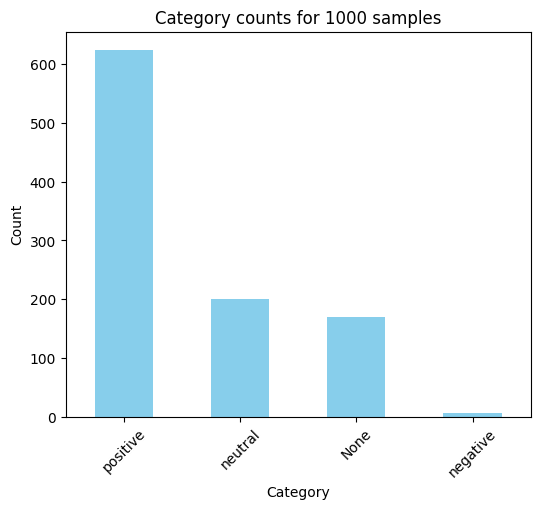

In [ ]:
counts = test.value_counts(dropna=False)

# bar chart of occurrences
plt.figure(figsize=(6, 5))
counts.plot(kind='bar', color='skyblue')
plt.title('Category counts for 1000 samples')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

From this, we can see that a majority of channel descriptions had positive sentiment. This makes sense, as channel descriptions are meant as advertisements to make people stay on the channel and subscribe. However, for our purposes the fact that most turn out to be positive or neutral means that there is not a lot of semantic meaning that can be derived from including this feature in the training model.

Ultimately, because of the time constraints and imbalance in categories resulting from a small sample of the data, we decided to focus on training and evaluating models rather than sentiment analysis.

## 3.4 Correlation Matrix
For numerical & binary data, we will perform a correlation analysis with a correlation matrix:

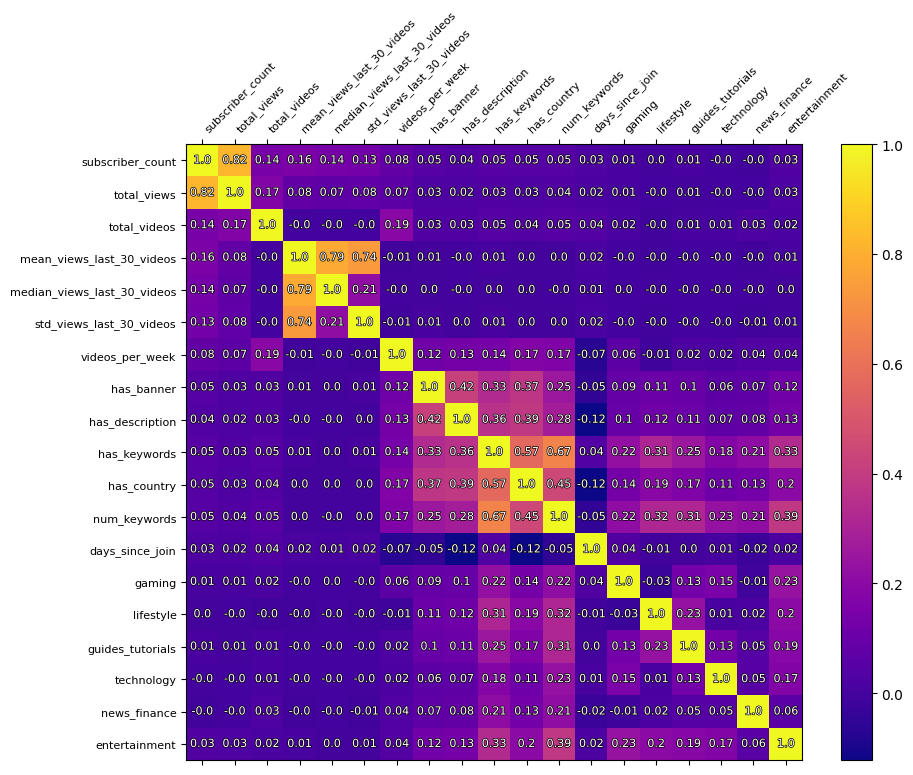

In [ ]:
num_data = ["subscriber_count", "total_views", "total_videos",
            "mean_views_last_30_videos", "median_views_last_30_videos",
            "std_views_last_30_videos", "videos_per_week",'has_banner',
            'has_description','has_keywords','has_country','num_keywords', 'days_since_join',
            'gaming', 'lifestyle', 'guides_tutorials', 'technology', 'news_finance', 'entertainment']
corr_matrix = yc_df_cleaned[num_data].corr()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.matshow(corr_matrix)
cax = ax.matshow(corr_matrix, interpolation='nearest', cmap='plasma')
fig.colorbar(cax)
# ax.legend()
plt.xticks(ticks=np.linspace(0, 18, len(num_data)), rotation=45, ha='left', fontsize=8)
plt.yticks(ticks=np.linspace(0, 18, len(num_data)), fontsize=8)
ax.set_xticklabels(num_data)
ax.set_yticklabels(num_data)

# add numbers to the boxes
for i in range(len(num_data)):
    for j in range(len(num_data)):
        text = ax.text(j, i, round(corr_matrix[num_data[i]][num_data[j]], 2),
                       ha="center", va="center", color="w", fontsize=8,
                       path_effects=[pe.withStroke(linewidth=1, foreground="black")])
plt.show()

The above correlation matrix indicates high correlation between certain sets of features but neutral correlation between most pairs.

Most significantly, total views on a channel are strongly correlated with subscriber count, the variable we aim to predict. This is indicative of real-world relationships, where subscribers make up a large portion of views on a channel, and having many views increases subscriber growth.

There is also some correlation between (total views, total videos, videos per week, monthly viewership statistics, number of keywords) and subscriber count, whereas the four binary encoded variables indicating presence or absence of banner, description, keywords, and country are all perfectly neutral.

The groups of features which are correlated with each other are `[mean, median, std views last 30 videos]` and `[has_banner, has_description, has_keywords, has_country]`.

## 3.5 Handling Skew in Subscriber Count
Our data is both extremely large (more than 1 million rows) and quite imbalanced. From EDA, we know the distribution of subscriber count is extremely left-skewed. The histogram above shows a dramatic imbalance in the frequency of labels, with lower subscriber counts having a much higher frequency.

Because we have a huge number of distinct labels, each distinct subscriber count being its own separate label, resampling is not as simple as simply undersampling or oversampling on certain categories.

Instead, as alluded to in the EDA phase, we can address the skew by transforming the subscriber count using a logarithmic scale. This helps normalize the data and reduce the skewness of the distribution. Log-transforming the target variable (subscriber count) will hopefully allow us to deal with the imbalanced distribution a lot better.

In [ ]:
yc_df_cleaned['sub_count_log'] = np.log1p(yc_df_cleaned['subscriber_count'])

# Part 4: Baseline Model Training

We are making predictions of a numerical value so a natural starting point is linear regression.


## 4.1 Linear Regression

In [ ]:
yc_df_cleaned.dtypes

channel_id                             object
channel_link                           object
channel_name                           object
subscriber_count                        int64
banner_link                            object
description                            object
keywords                               object
avatar                                 object
country                                object
total_views                           float64
total_videos                          float64
join_date                      datetime64[ns]
mean_views_last_30_videos             float64
median_views_last_30_videos           float64
std_views_last_30_videos              float64
videos_per_week                       float64
days_since_join                         int64
has_banner                            float64
has_description                       float64
has_keywords                          float64
has_country                           float64
has_links                         

In [ ]:
new_ver = yc_df_cleaned.copy()

Here, we have decided to work with only the numerical features from the original dataset as well as numerical features we created via feature engineering. `channel_id`, `channel_link`, `channel_name,` and `avatar` were ultimately dropped since its unclear how these strings would have any relationship with final subscriber count. Unlike `banner_link`, `description`, `keywords`, and `country`, no binary feature indicating their presence or absence was created because none of those attributes contained null values in the dataset. As such, binary versions of `channel_id`, `channel_link`, `channel_name,` and `avatar` would feature a value of 1 for all rows, adding unnecessary complexity to our calculations while providing no additional insight.

In [ ]:
# select features for training the model
feature_names = ['total_views', 'total_videos', 'mean_views_last_30_videos', 'median_views_last_30_videos',
                          'std_views_last_30_videos', 'videos_per_week', 'days_since_join', 'has_banner',
                          'has_description', 'has_keywords', 'has_country', 'num_keywords',
                 'gaming', 'lifestyle', 'guides_tutorials', 'technology', 'news_finance', 'entertainment']
pre_split = new_ver[feature_names + ['subscriber_count'] + ['sub_count_log']]

In [ ]:
pre_split.isnull().any(axis=1).sum()

0

In [ ]:
# Split the data into features and target
pre_split = pre_split.dropna() # Drop rows with null values
features = pre_split[feature_names]
target = pre_split['subscriber_count']
log_target = pre_split['sub_count_log']

In [ ]:
from sklearn.metrics import mean_absolute_error
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=31)

# Training the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.2f}')
y_pred

RMSE: 455656.43
R² Score: 0.6731
MAE: 64471.76


array([-37199.33084309, 122348.22940023,  27789.09659673, ...,
       -21451.54513797,  -5972.59473066,  78368.49173817])

In [ ]:
features.dtypes

total_views                    float64
total_videos                   float64
mean_views_last_30_videos      float64
median_views_last_30_videos    float64
std_views_last_30_videos       float64
videos_per_week                float64
days_since_join                  int64
has_banner                     float64
has_description                float64
has_keywords                   float64
has_country                    float64
num_keywords                     int64
gaming                           int64
lifestyle                        int64
guides_tutorials                 int64
technology                       int64
news_finance                     int64
entertainment                    int64
dtype: object

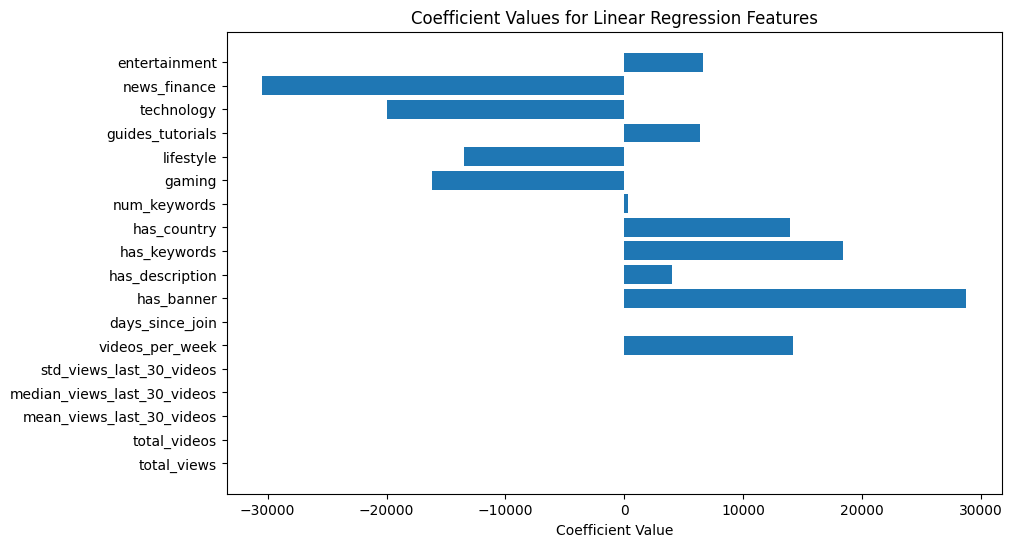

In [ ]:
# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_names, model.coef_)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values for Linear Regression Features')
plt.show()

**Baseline Linear Regression Performance:**

RMSE: This value means that on average, the model's predictions deviate from the actual subscriber counts by approximately 483,070 subscribers. Considering subscriber counts can range widely among YouTube channels, if typical subscriber counts are in the millions, this error might be tolerable. Considering that our data is heavily skewed to the right, though, this error seems to be quite large.

R² Score: The R² score of 0.67 indicates that about 67% of the variance in the subscriber count is explained by the model. This suggests a moderate level of predictive accuracy, which is not bad for a baseline model, especially without fine-tuning or complex feature engineering.

A reason why the RMSE is so large could be because we have some insane outliers that the model will get drastically wrong, given the baseline model's lower complexity and thus higher bias.

## 4.2 Other Models to Consider

**Random Forest Regressor:**

Why: Random Forests handle non-linearity by using multiple decision trees to make predictions (bagging), which can model more complex patterns than linear regression. They are also robust against overfitting, especially if there are many features and less noise.

Benefits: Provides feature importance scores, helping to understand which variables most strongly predict subscriber counts. It's also less sensitive to outliers than linear regression.

**Gradient Boosting:**

Why: Boosting reduces bias, adding complexity to the model, thus often leading to better predictive performance.

Benefits: They can handle various types of data, including features that might not have linear relationships. They also include mechanisms to prevent overfitting through the use of shallow trees and learning rates.



**Ridge/Lasso Regression:**

Why: As a variant of linear regression that includes L2/L1 regularization, Ridge/Lasso Regression can be effective if the prediction error is due to a high variance in the model. Lasso can set some coefficients to 0 while the coefficients will never go exactly to 0 in ridge. The regularization helps reduce model complexity and prevent overfitting.

Benefits: It works well when there is multicollinearity in data (which we know there is from the correlation matrix) or when the dataset features outnumber the data points. It can also reduce the impact of less important features.

In summary, we need to increase complexity and introduce non-linearity and be more robust to outliers and overfitting, so that we can improve the performance compared to the baseline linear regression model.

# Part 5: Dimensionality Reduction


We have identified the large imbalance in our target variable (`subscriber_count`) as an impediment to model accuracy, and have compensated by creating an alternate target label `sub_count_log`, i.e. the log of the subscriber count.

In addition, as seen in the Correlation Matrix in 3.4, we have many features that are highly correlated (e.g. `mean_views_last_30_videos` and `median_views_last_30_videos`). This, along with the fact that we have a large number of features, means it will be helpful to use dimensionality reduction to simplify the data prior to running the rest of our models.

In [ ]:
numerical_features = ['total_views', 'total_videos', 'mean_views_last_30_videos', 'median_views_last_30_videos',
                          'std_views_last_30_videos', 'videos_per_week', 'days_since_join', 'num_keywords']
binary_features = ['has_banner', 'has_description', 'has_keywords', 'has_country', 'gaming', 'lifestyle',
                   'guides_tutorials', 'technology', 'news_finance', 'entertainment']
X = yc_df_cleaned[numerical_features + binary_features]
y = yc_df_cleaned['subscriber_count']
y_log = yc_df_cleaned['sub_count_log']

## 5.1 Normalization

Many of the numerical features are on wildly different scales. For example, `total_views` can enter the millions while `total_videos` can be estimated to be in the hundreds at most. To have all the features be weighted the same amount in training, we normalize them here.

In [ ]:
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
X_train_log1, X_test_log1, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=31)

In [ ]:
X_train = X_train1.copy()
X_test = X_test1.copy()
X_train_log = X_train_log1.copy()
X_test_log = X_test_log1.copy()

# Initializing scaler
scaler = StandardScaler()
scaler2 = StandardScaler()

# Fitting and transforming on the training set
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train_log[numerical_features] = scaler2.fit_transform(X_train_log[numerical_features])
X_test_log[numerical_features] = scaler2.transform(X_test_log[numerical_features])

## 5.2 PCA

In [ ]:
# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
pca.fit(X_train)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

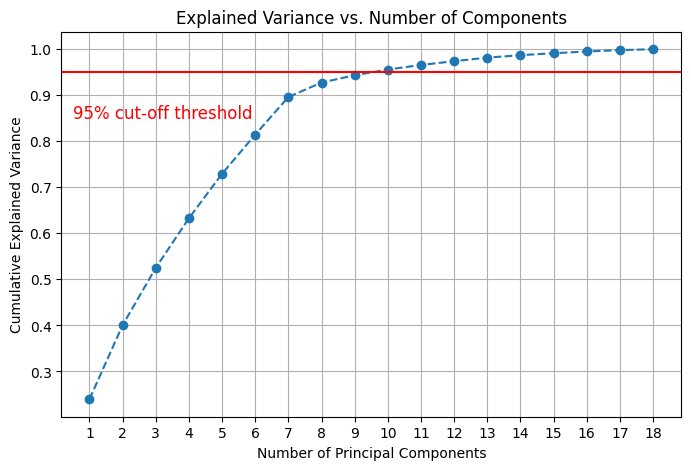

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.xticks(range(1, len(cumulative_explained_variance) + 1))  # This ensures we have a tick for each component
plt.axhline(y=0.95, color='r', linestyle='-')  # Add a horizontal line at 95% variance
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.show()

As seen from the plot, we should keep 10 principal components if we want to capture 95% of the variance. We do this in the following code block, and the following models employ PCA-reduced data.

In [ ]:
pca2 = PCA(n_components=10)
X_train_pca = pca2.fit_transform(X_train)
X_test_pca = pca2.transform(X_test)

X_train_log_pca = pca2.fit_transform(X_train_log)
X_test_log_pca = pca2.transform(X_test_log)

# Part 6: Modeling

## 6.1 Linear Regression Revisited

We try linear regression again, on the normalized PCA data, for both y and y_log. This will help us determine if taking the log of subscriber count actually helps.

In [ ]:
# Training the Linear Regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Making predictions
y_pred = model.predict(X_test_pca)

# Evaluating the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2_train = model.score(X_train_pca, y_train)
r2_test = model.score(X_test_pca, y_test)

# Print results
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R² Score Train: {r2_train:.4f}')
print(f'R² Score Test: {r2_test:.4f}')

RMSE: 458196.81
MAE: 64583.43
R² Score Train: 0.6904
R² Score Test: 0.6694


In [ ]:
# Training the Linear Regression model
model2 = LinearRegression()
model2.fit(X_train_log_pca, y_train_log)

# Making predictions
y_pred_log = model2.predict(X_test_log_pca)

# Evaluating the model
rmse_log = mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_log), squared=False)
mae_log = mean_absolute_error(np.expm1(y_test_log), np.expm1(y_pred_log))
r2_train_log = model2.score(X_train_log_pca, y_train_log)
r2_test_log = model2.score(X_test_log_pca, y_test_log)

# Print results
print(f'RMSE: {rmse_log:.2f}')
print(f'MAE: {mae_log:.2f}')
print(f'R² Score Train: {r2_train_log:.4f}')
print(f'R² Score Test: {r2_test_log:.4f}')

RMSE: 267592139808646048282790854656.00
MAE: 572046749934632083214303232.00
R² Score Train: 0.3505
R² Score Test: 0.3517


We can see that performance actually decreases using log of subscriber count. This does not mean that log-transforming subscriber count isn't helpful at all; it just might be because linear regression can only find linear relationships, and by transforming the target variable non-linearly, perhaps some relationships are harder to model using just linear regression. Additionally, PCA does not seem to make much of a difference in terms of $R^2$ score because it is mainly used to help with overfitting. Our problem here is not overfitting; we are underfitting. Therefore, we opt to use the non-PCA data for the next few models. Additionally, we will see if the log-transformed data makes any difference for more complex models.

## 6.2 Linear Regression with Regularization

We will attempt regularization with both Ridge and Elastic Net. We decline to use Lasso because our use of PCA has already allowed us to simplify our feature space, which is what Lasso is primarily designed to do.

We elect to use grid search without cross-validation because our dataset is sufficiently large. Cross-validation can be very useful if the dataset is not massive, but ours is around 1 million rows.

### 6.2.1 Ridge Regression

In [ ]:
# Function to run ridge regression while varying the strength of regularization.
def ridge(features_train, features_test, labels_train, labels_test):
  best_r2 = 0
  best_alpha = 0
  # Custom grid search without cross-validation
  for a in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100, 500, 1000, 4000, 10000, 40000, 100000, 500000, 1000000]:
    # train a Ridge regression model with the given alpha
    ridge = Ridge(alpha = a)
    ridge = ridge.fit(features_train, labels_train)
    pred = ridge.predict(features_test)
    # Evaluating the model
    rmse_temp = mean_squared_error(labels_test, pred, squared=False)
    # Take the error of the exponential of predictions when using log sub count
    if labels_test.dtypes == 'float64':
      rmse_temp = mean_squared_error(np.expm1(labels_test), np.expm1(pred), squared=False)
    r2_train_temp = ridge.score(features_train, labels_train)
    r2_temp = r2_score(labels_test, pred)
    # Print results
    print(f'RMSE: {rmse_temp:.2f}')
    print(f'R² Score Train: {r2_train_temp:.4f}')
    print(f'R² Score Test: {r2_temp:.4f}')
    # If new best, store the score and parameters
    if r2_temp > best_r2:
      best_alpha = a
      best_r2 = r2_temp
  print("Best score: {:.4f}".format(best_r2))
  print("Best alpha: {}".format(best_alpha))

Here, we run Ridge regression using both subscriber counts and the log of subscriber counts.


In [ ]:
ridge(X_train_pca, X_test_pca, y_train, y_test)
ridge(X_train_log_pca, X_test_log_pca, y_train_log, y_test_log)

RMSE: 458196.79
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458196.78
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458196.73
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458196.64
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458196.48
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458195.99
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458195.16
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458188.59
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458180.38
R² Score Train: 0.6904
R² Score Test: 0.6694
RMSE: 458114.85
R² Score Train: 0.6904
R² Score Test: 0.6695
RMSE: 458033.37
R² Score Train: 0.6904
R² Score Test: 0.6696
RMSE: 457554.41
R² Score Train: 0.6904
R² Score Test: 0.6703
RMSE: 456646.57
R² Score Train: 0.6903
R² Score Test: 0.6716
RMSE: 453037.07
R² Score Train: 0.6891
R² Score Test: 0.6768
RMSE: 449692.94
R² Score Train: 0.6833
R² Score Test: 0.6816
RMSE: 483350.22
R² Score Train: 0.6028
R² Score Test: 0.6321
RMSE: 541442.21
R² Score

Similar to linear regression, ridge regression does not perform well on the log-transformed data. Using the original subscriber count as the labels, we get an $R^2$ of 0.68 and we get an $R^2$ of 0.35 using the log-transformed labels. This is not much of an improvement over vanilla linear regression, which indicates that we are not overfitting; instead, we are probably still underfitting.

### 6.2.2 Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet
# Function to run elastic net regression while varying the regularization strength and relative weights of
# l1 and ridge
def elastic_net(features_train, features_test, labels_train, labels_test):
  best_r2 = 0
  best_alpha = 0
  best_l1_rat = 0
  # Custom grid search without cross-validation
  for a in [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100, 500, 1000, 4000, 10000, 40000, 100000, 500000, 1000000]:
    for l1_rat in [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]:
      # train a ElasticNet regression model with the given alpha plus l1_ratio
      e_net = ElasticNet(alpha = a, l1_ratio = l1_rat)
      e_net = e_net.fit(features_train, labels_train)
      pred = e_net.predict(features_test)
      # Evaluating the model
      rmse_temp = mean_squared_error(labels_test, pred, squared=False)
      # Take the error of the exponential of predictions when using log sub count
      if labels_test.dtypes == 'float64':
        rmse_temp = mean_squared_error(np.expm1(labels_test), np.expm1(pred), squared=False)
      r2_train_temp = e_net.score(features_train, labels_train)
      r2_temp = r2_score(labels_test, pred)
      # Print results
      print(f'RMSE: {rmse_temp:.2f}')
      print(f'R² Score Train: {r2_train_temp:.4f}')
      print(f'R² Score Test: {r2_temp:.4f}')
      # If new best, store the score and parameters
      if r2_temp > best_r2:
        best_alpha = a
        best_l1_rat = l1_rat
        best_r2 = r2_temp
  print("Best score: {:.4f}".format(best_r2))
  print("Best alpha: {}".format(best_alpha))
  print("Best l1_rat: {}".format(best_l1_rat))

As with Ridge Regression, we run Elastic Net using both the original labels and log of the labels

In [ ]:
elastic_net(X_train_pca, X_test_pca, y_train, y_test)
elastic_net(X_train_log_pca, X_test_log_pca, y_train_log, y_test_log)

RMSE: 450361.20
R² Score: 0.6806
RMSE: 450791.06
R² Score: 0.6800
RMSE: 451947.55
R² Score: 0.6784
RMSE: 453535.53
R² Score: 0.6761
RMSE: 455601.54
R² Score: 0.6731
RMSE: 456829.61
R² Score: 0.6714
RMSE: 450118.37
R² Score: 0.6810
RMSE: 449684.55
R² Score: 0.6816
RMSE: 449606.38
R² Score: 0.6817
RMSE: 450791.04
R² Score: 0.6800
RMSE: 453535.50
R² Score: 0.6761
RMSE: 455601.51
R² Score: 0.6731
RMSE: 470472.66
R² Score: 0.6515
RMSE: 465483.55
R² Score: 0.6588
RMSE: 456707.35
R² Score: 0.6716
RMSE: 450778.93
R² Score: 0.6800
RMSE: 450023.56
R² Score: 0.6811
RMSE: 452684.71
R² Score: 0.6773
RMSE: 518373.40
R² Score: 0.5769
RMSE: 508057.29
R² Score: 0.5936
RMSE: 486492.01
R² Score: 0.6273
RMSE: 465483.75
R² Score: 0.6588
RMSE: 450779.01
R² Score: 0.6800
RMSE: 450023.52
R² Score: 0.6811
RMSE: 590423.89
R² Score: 0.4511
RMSE: 577421.67
R² Score: 0.4750
RMSE: 546511.98
R² Score: 0.5297
RMSE: 508057.85
R² Score: 0.5935
RMSE: 465484.15
R² Score: 0.6588
RMSE: 450779.16
R² Score: 0.6800
RMSE: 6835

We see $R^2$ values of 0.68 and 0.34 for original and log-transformed, respectively. This is again indicative of underfitting rather than overfitting. This tells us that a linear model is simply not complex enough to model the relationships.

## 6.3 Random Forest

Seeing as linear regression and linear regression with regularization were resulting in subpar $R^2$ values, we turned to ensemble methods. Random forests are an example of bagging, in which multiple decision trees are grown out and combined to form the regressor. We hoped that random forests would allow us to model nonlinear relationships. Because Random Forests are built on top of decision trees, which are scale invariant, we decided not to use PCA-transformed or log-transformed data.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def rand_forest(features_train, features_test, labels_train, labels_test):
  best_m = 0
  best_n = 0
  best_r2 = 0
  for m in [3, 5, 8, 12]:
    for n in [10, 20, 50, 100]:
      regressor = RandomForestRegressor(n_estimators=n, max_depth=m)
      regressor = regressor.fit(features_train, labels_train)
      pred = regressor.predict(features_test)
      # Evaluating the model
      rmse_temp = mean_squared_error(labels_test, pred, squared=False)
      mae_temp = mean_absolute_error(labels_test, pred)
      if labels_test.dtypes == 'float64':
        rmse_temp = mean_squared_error(np.expm1(labels_test), np.expm1(pred), squared=False)
        mae_temp = mean_absolute_error(np.expm1(labels_test), np.expm1(pred))
      r2_train_temp = regressor.score(features_train, labels_train)
      r2_temp = r2_score(labels_test, pred)
      # Print results
      print(f'RMSE: {rmse_temp:.2f}')
      print(f'MAE: {mae_temp:.2f}')
      print(f'R² Score Train: {r2_train_temp:.4f}')
      print(f'R² Score Test: {r2_temp:.4f}')
      # If new best, store the score and parameters
      if r2_temp > best_r2:
        best_m = m
        best_n = n
        best_r2 = r2_temp
  print("Best score: {:.2f}".format(best_r2))
  print("Best m: {}".format(best_m))
  print("Best n: {}".format(best_n))

In [ ]:
rand_forest(X_train, X_test, y_train, y_test)

RMSE: 410429.74
MAE: 48171.77
R² Score Train: 0.7633
R² Score Test: 0.7347
RMSE: 407064.90
MAE: 47995.89
R² Score Train: 0.7636
R² Score Test: 0.7391
RMSE: 404710.92
MAE: 46724.51
R² Score Train: 0.7671
R² Score Test: 0.7421
RMSE: 401533.08
MAE: 47195.24
R² Score Train: 0.7667
R² Score Test: 0.7461
RMSE: 391755.64
MAE: 36357.33
R² Score Train: 0.8282
R² Score Test: 0.7583
RMSE: 399557.28
MAE: 36490.05
R² Score Train: 0.8329
R² Score Test: 0.7486
RMSE: 401125.66
MAE: 36357.10
R² Score Train: 0.8334
R² Score Test: 0.7466
RMSE: 389830.15
MAE: 36182.57
R² Score Train: 0.8378
R² Score Test: 0.7607
RMSE: 399704.38
MAE: 33963.72
R² Score Train: 0.8838
R² Score Test: 0.7484
RMSE: 376082.34
MAE: 33469.28
R² Score Train: 0.8878
R² Score Test: 0.7773
RMSE: 380202.97
MAE: 33553.93
R² Score Train: 0.8833
R² Score Test: 0.7724
RMSE: 384435.01
MAE: 33611.14
R² Score Train: 0.8890
R² Score Test: 0.7673
RMSE: 412860.46
MAE: 33678.90
R² Score Train: 0.9238
R² Score Test: 0.7316
RMSE: 388631.06
MAE: 3312

We can see that with 20 estimators and a max depth of 8, we get an $R^2$ of 0.78, which is quite a bit better than our previous $R^2$ values of around 0.66 to 0.68. This is most likely due to the random forest's ability to fit to nonlinear relationships better. We do, however, see that the training $R^2$ is quite a bit higher, at 0.88. This could indicate some overfitting. Even though random forests are more robust to overfitting, if the data is noisy, or features aren't tuned properly, it can still overfit.

## 6.4 Gradient Boosting

Due to the high likelihood of underfitting, as seen from the linear regression, we also trained a gradient boosting model. Boosting, like bagging, is also an ensemble method. It combines multiple weak learners to create a more complex model. That is, boosting is great at reducing bias, and our previous models, which underfitted, had high bias. Additionally, this is great for capturing nonlinear relationships as well. Since boosting is known to help with underfitting, we expected this to perform the best.

We started off doing grid search on both the dataset with original subscriber count and log-transformed subscriber count.

In [ ]:
# Grid search on data with original subscriber count
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(seed=31),
                           param_grid=params,
                           scoring='r2',
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4}
Best score:  0.4121919975129309


In [ ]:
# Grid search on log-transformed subscriber count
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(seed=31),
                           param_grid=params,
                           scoring='r2',
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_log, y_train_log)
print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 8}
Best score:  0.8297065086278832


In [ ]:
# Model for original subscriber count
xgb_reg = xgb.XGBRegressor(eta=0.1, max_depth=4, seed=31)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluating the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBRegressor on original count - MSE: {mse_xgb:.2f}, R-squared: {r2_xgb:.2f}')

# Model for logarithmic transformed subscriber count
xgb_reg_log = xgb.XGBRegressor(eta=0.1, max_depth=8, seed=31)
xgb_reg_log.fit(X_train_log, y_train_log)
y_log_pred_xgb = xgb_reg_log.predict(X_test_log)

# Evaluating the model
mse_log_xgb = mean_squared_error(np.expm1(y_test_log), np.expm1(y_log_pred_xgb), squared=False)
r2_log_xgb = r2_score(y_test_log, y_log_pred_xgb)
print(f'XGBRegressor on log-transformed count - MSE: {mse_log_xgb:.2f}, R-squared: {r2_log_xgb:.2f}')

XGBRegressor on original count - MSE: 593860.24, R-squared: 0.44
XGBRegressor on log-transformed count - MSE: 604488.26, R-squared: 0.83


Here, we calculate the $R^2$ score for training data to check for overfitting.

In [ ]:
# Training score
xgb_reg.score(X_train, y_train)

0.563812715086579

In [ ]:
# Training score for log scale
xgb_reg_log.score(X_train_log, y_train_log)

0.8415204683184728

Remarkably, gradient boosting performs significantly better on log scale data than the original data. This supports our original hypothesis that some skew would be removed, helping the model perform better. Contrast this with linear regression which had the opposite effect. We also see that the train $R^2$ and test $R^2$ are similar, which means we aren't overfitting. Gradient boosting gives us the best $R^2$ score of 0.83.

# Part 7: Conclusion


**Main takeaways:**


*   The factors that influence subscriber count seem to be quite complex. Even with feature engineering, it was difficult to train models that fit the data well. Perhaps there are other factors that are not represented in the dataset that play a role.
*   Due to the nature of our dataset, including heavy skew, outliers, and being quite sparse in general, these factors made it difficult for most models to achieve low error and high $R^2$ values.
*   Ensemble methods proved to be an important player, as we saw random forest and gradient boosting significantly outperform earlier models. This supports the concepts we learned in class about bagging and boosting.
*   The best model was gradient boosting, with a score of 0.83. This means that the proportion of the variation in the subscriber count that is predictable from the features is quite good. Additionally, it did not overfit, which means that the model was able to capture some underlying patterns relating the features to the labels.

**Potential future modifications:**

*   There is potential to do even more feature engineering utilizing techniques such as NLP for sentiment analysis on textual data.
*   Neural networks could add complexity and perhaps be able to find more complex relationships.
*   Joining on different datasets to get a richer set of features might be able to help.
*   In addition to getting more features, we would then use techniques like PCA or recursive feature elimination to reduce dimensionality, helping with computational cost and decreasing risk of overfitting.









